# Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

In [4]:
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.precision', 2)

# Create Census Data

In [181]:
age=pd.read_csv("../data/acs/ACSDT5Y2019.B01002_2020-12-15T021141/data.csv",skiprows=1).iloc[:,[0,2]]
age['id']=age["id"].apply(lambda x:x[-5:])
age=age.rename({"Estimate!!Median age --!!Total:":"median_age"},axis=1)

In [182]:
pop=pd.read_csv("../data/acs/ACSDT5Y2019.B01003_2020-12-15T021819/data.csv",skiprows=1).iloc[:,[0,2]]
pop['id']=pop["id"].apply(lambda x:x[-5:])
pop=pop.rename({"Estimate!!Total":"pop","Geographic Area Name":"County Name"},axis=1)

In [183]:
race=pd.read_csv("../data/acs/ACSDT5Y2019.B02001_2020-12-15T045802/data.csv",skiprows=1).iloc[:,[0,6]]
race['id']=race["id"].apply(lambda x:x[-5:])
race=race.rename({"Estimate!!Total:!!Black or African American alone":"african_american",},axis=1)

In [185]:
inc=pd.read_csv("../data/acs/ACSDT5Y2019.B07011_2020-12-15T060656/data.csv",skiprows=1).iloc[:,[0,2]]
inc['id']=inc["id"].apply(lambda x:x[-5:])
inc=inc.rename({"Estimate!!Median income in the past 12 months --!!Total:":"median_income",},axis=1)

In [186]:
lnd=pd.read_excel('../data/acs/LND01.xls')
lnd=lnd[['STCOU','LND110210D']]
lnd=lnd.rename({'STCOU':'id','LND110210D':'area'},axis=1)
lnd['id']=lnd['id'].apply(lambda x: str(x).zfill(5))

In [187]:
dataframes=[age,pop,race,inc,lnd]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['id']), dataframes)

In [188]:
df_merged['pop_density']=df_merged['pop']/df_merged['area']

In [190]:
df_merged.to_csv("../data/census.csv")

In [55]:
se=pd.read_csv('../data/socialexplorer/socialexplorer.csv',encoding = "ISO-8859-1")

In [56]:
tables=['T001_001','T002_002','T008_010','T008_011','T008_012','T008_013','T044_001','T054_003','T055_010']
names=[]
tables=['SE_'+ t for t in tables]
se=se[['Geo_FIPS']+tables].copy()
se['over65']=se.iloc[:,3:7].sum(axis=1)
se=se.drop(se.columns[3:7],axis=1)
se=se.rename(columns=dict(zip(se.columns, ['fips','pop','pop_density','median_age','afr','hisp','over65'])))

In [57]:
se[['afr','hisp','over65']]=se[['afr','hisp','over65']].div(se['pop'],axis=0)*100

In [58]:
se

,fips,pop,pop_density,median_age,afr,hisp,over65
0,1001,54571,91.80297,37.0,17.670558,2.400542,22.733686
1,1003,182265,114.64760,41.1,9.384687,4.384824,30.232354
2,1005,27457,31.02920,39.0,46.891503,5.051535,27.406490
3,1007,22915,36.80638,37.8,22.024875,1.771765,24.617063
4,1009,57322,88.90221,39.0,1.327588,8.070200,27.415303
...,...,...,...,...,...,...,...
3216,72145,59662,1301.06900,36.5,11.469612,99.264188,25.589152
3217,72147,9301,183.20610,40.0,28.136759,94.344694,30.297817
3218,72149,26073,731.63400,33.4,8.483872,99.654815,22.191539
3219,72151,37941,687.15520,36.7,14.058670,99.327904,25.521204


In [59]:
se.to_csv("../data/socialexplorer.csv")

# Create Panel 

In [117]:
cov=pd.read_csv("../data/covid.csv")

In [118]:
cases=cov[cov['date']=='2020-12-13'][['cases','fips','county','state']]

In [109]:
spend=pd.read_csv("../data/EconomicTracker-main/Affinity - County - Daily.csv")


In [71]:
#spend=spend[(spend['freq']=='d')&(spend['month']==10)&(spend['day']==31)&(spend['spend_all'].notna())][['spend_all','countyfips']]

In [110]:
#Method 2
spend=spend[(spend['freq']=='d')&(spend['spend_all'].notna())]#[['spend_all','countyfips']]

In [111]:
spend=spend.groupby(['countyfips'])['spend_all'].mean().reset_index()
spend=spend.rename({"countyfips":"fips"},axis=1)

In [90]:
emp= pd.read_csv("../data/EconomicTracker-main/Employment Combined - County - Daily.csv")

In [100]:
emp['emp_combined']=emp['emp_combined'].apply(lambda x: None if x=='.' else float(x))
emp=emp.dropna().reset_index(drop=True)
emp=emp.groupby('countyfips')['emp_combined'].mean().reset_index().rename({"countyfips":"fips"},axis=1)

In [102]:
sme= pd.read_csv("../data/EconomicTracker-main/Womply Merchants - County - Daily.csv")

In [103]:
sme=sme.groupby("countyfips")['merchants_all'].mean().reset_index().rename({"countyfips":"fips"},axis=1)

In [113]:
economictracker=pd.merge(pd.merge(emp,sme,on="fips",how="outer"),spend,on="fips",how="outer")

In [114]:
economictracker.to_csv("../data/economictracker.csv")

In [121]:
merged=pd.merge(cases,economictracker,on="fips")

In [122]:
merged

,cases,fips,county,state,emp_combined,merchants_all,spend_all
0,3300,1001.0,Autauga,Alabama,NaN,NaN,-0.016483
1,10806,1003.0,Baldwin,Alabama,0.001396,-0.233571,-0.063427
2,3776,1009.0,Blount,Alabama,NaN,NaN,-0.034662
3,7813,1015.0,Calhoun,Alabama,-0.043281,-0.135081,-0.030890
4,1197,1019.0,Cherokee,Alabama,NaN,NaN,-0.135955
...,...,...,...,...,...,...,...
1777,540,56035.0,Sublette,Wyoming,NaN,NaN,-0.099363
1778,2451,56037.0,Sweetwater,Wyoming,NaN,NaN,-0.165431
1779,1905,56039.0,Teton,Wyoming,-0.056420,NaN,-0.123923
1780,1307,56041.0,Uinta,Wyoming,NaN,NaN,0.097779


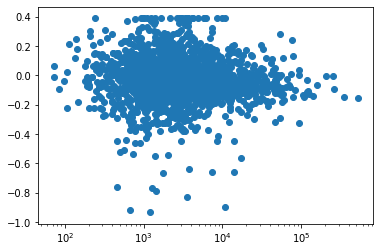

In [74]:
plt.scatter(x="cases",y="spend_all",data=merged)
plt.xscale('log')

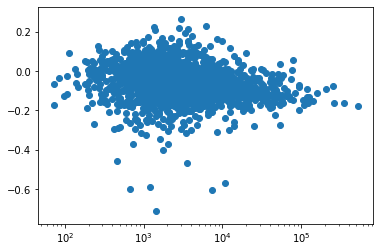

In [64]:
plt.scatter(x="cases",y="spend_all",data=merged)
plt.xscale('log')

In [127]:
se=pd.read_csv('../data/socialexplorer.csv')
census=pd.read_csv('../data/census.csv')

In [129]:
census=census.rename({'id':'fips'},axis=1)

In [130]:
census

,Unnamed: 0,fips,median_age,pop,african_american,median_income,area,pop_density
0,0,1001,38.2,55380,10538,29725.0,594.44,93.163313
1,1,1003,43.0,212830,19718,29802.0,1589.78,133.873869
2,2,1005,40.4,25361,12066,17963.0,884.88,28.660383
3,3,1007,40.9,22493,5014,21958.0,622.58,36.128690
4,4,1009,40.7,57681,928,26976.0,644.78,89.458420
...,...,...,...,...,...,...,...,...
3135,3135,56037,35.3,43521,502,36512.0,10426.65,4.174016
3136,3136,56039,39.3,23280,290,40914.0,3995.38,5.826730
3137,3137,56041,35.8,20479,23,29557.0,2081.26,9.839712
3138,3138,56043,42.9,8027,3,29327.0,2238.55,3.585803


In [131]:
merged=pd.merge(merged,se[["median_age","pop","fips",'pop_density',"afr","hisp","over65"]],on='fips')

In [134]:
merged=pd.merge(census[['fips','median_income']],merged,on="fips")

In [136]:
merged['casesper100k']=merged['cases']/100000

In [137]:
merged.to_csv("../data.csv")

In [138]:
merged=pd.read_csv('../data.csv')

In [139]:
merged.columns

Index(['Unnamed: 0', 'fips', 'median_income', 'cases', 'county', 'state',
       'emp_combined', 'merchants_all', 'spend_all', 'median_age', 'pop',
       'pop_density', 'afr', 'hisp', 'over65', 'casesper100k'],
      dtype='object')

In [141]:
merged['casesper100k'].max()

5.25651

In [142]:
merged['median_income'].median()

28390.0

In [143]:
merged['highincome']=merged['median_income']>30000

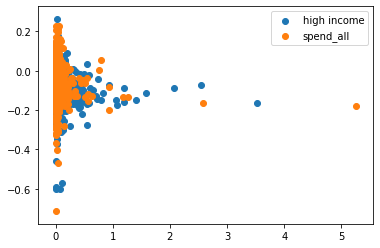

In [147]:
plt.scatter(x="casesper100k",y="spend_all",data=merged[merged['highincome']],label="high income")
plt.scatter(x="casesper100k",y="spend_all",data=merged[~merged['highincome']])

plt.legend()

In [14]:
merged[]['cases'].max()

525651